In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Function
import numpy as np
from torch.cuda.amp import autocast, GradScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
state_dict = torch.load("woBN_qat_bnn_model.pth")
npy_dict = {
        "conv1w": state_dict["conv1.weight"].sign().cpu().numpy(),
        "conv2w": state_dict["conv2.weight"].sign().cpu().numpy(),
        "conv3w": state_dict["conv3.weight"].sign().cpu().numpy(),
        "fc1w": state_dict["fc1.weight"].sign().cpu().numpy(),
        "fc1b": state_dict["fc1.bias"].cpu().numpy(),
    }
np.save("qat_bnn_model.npy", npy_dict)

In [5]:
# === threshold 계산 함수 ===
def bn_to_threshold(bn_layer):
    gamma = bn_layer.weight.detach().cpu().numpy()
    beta = bn_layer.bias.detach().cpu().numpy()
    mean = bn_layer.running_mean.detach().cpu().numpy()
    var = bn_layer.running_var.detach().cpu().numpy()
    eps = bn_layer.eps

    alpha = gamma / np.sqrt(var + eps)
    bias = beta - alpha * mean
    threshold = -bias / alpha
    return threshold

def threshold_activation(x, threshold):
    th = torch.from_numpy(threshold).to(x.device)
    if x.dim() == 4:
        th = th.view(1, -1, 1, 1)
    elif x.dim() == 2:
        th = th.view(1, -1)
    else:
        raise ValueError(f"Unsupported input shape: {x.shape}")
    return (x > th).float() * 2 - 1

# === Inference-only Binarized 모델 ===
class BinarizedInferenceBNN(nn.Module):
    def __init__(self, qat_model):
        super().__init__()

        # Binary weights
        self.conv1_weight = qat_model.conv1.weight.data.sign()
        self.conv2_weight = qat_model.conv2.weight.data.sign()
        self.conv3_weight = qat_model.conv3.weight.data.sign()
        self.fc1_weight   = qat_model.fc1.weight.data.sign()
        self.fc1_bias     = qat_model.fc1.bias.data


        # Thresholds from BatchNorm
        #self.th1 = bn_to_threshold(qat_model.bn1)
        #self.th2 = bn_to_threshold(qat_model.bn2)
        #self.th3 = bn_to_threshold(qat_model.bn3)
        #self.th_fc = bn_to_threshold(qat_model.bn_fc)

        self.pool = nn.AvgPool2d(2)

    def forward(self, x):
        x = F.conv2d(x, self.conv1_weight, None, stride=1)
        x = x.sign()
        #x = threshold_activation(x, self.th1)

        x = F.conv2d(x, self.conv2_weight, None, stride=1)
        x = x.sign()
        #x = threshold_activation(x, self.th2)

        x = F.conv2d(x, self.conv3_weight, None, stride=1)
        x = x.sign()
        #x = threshold_activation(x, self.th3)

        x = self.pool(x)
        x = torch.flatten(x, 1)

        #x = threshold_activation(x, self.th_fc)
        x = F.linear(x, self.fc1_weight, self.fc1_bias)

        return F.log_softmax(x, dim=1)


In [27]:
state_dict["conv1.weight"] = state_dict["conv1.weight"].sign()
state_dict["conv2.weight"] = state_dict["conv2.weight"].sign()
state_dict["conv3.weight"] = state_dict["conv3.weight"].sign()
state_dict["fc1.weight"] = state_dict["fc1.weight"].sign()
state_dict["fc1.bias"] = state_dict["fc1.bias"].sign()
state_dict

OrderedDict([('conv1.weight',
              tensor([[[[-1., -1.,  1.],
                        [ 1., -1.,  1.],
                        [ 1.,  1.,  1.]]],
              
              
                      [[[-1., -1., -1.],
                        [ 1., -1., -1.],
                        [-1.,  1., -1.]]],
              
              
                      [[[-1., -1.,  1.],
                        [ 1.,  1., -1.],
                        [ 1.,  1., -1.]]],
              
              
                      [[[ 1., -1., -1.],
                        [ 1., -1.,  1.],
                        [ 1.,  1.,  1.]]],
              
              
                      [[[ 1., -1.,  1.],
                        [-1., -1.,  1.],
                        [ 1., -1., -1.]]],
              
              
                      [[[-1.,  1.,  1.],
                        [ 1.,  1., -1.],
                        [-1., -1., -1.]]],
              
              
                      [[[-1.,  1., -1.],

In [28]:
from bnn_learn import QATBNN  # 원래 모델 정의

# 1. 원래 학습용 모델 정의 & 로드
qat_model = QATBNN()
#state_dict = torch.load("best_qat_bnn_model.pth", map_location='cpu')
qat_model.load_state_dict(state_dict)
qat_model.eval()

# 2. Inference-only BNN으로 변환
inference_model = BinarizedInferenceBNN(qat_model)
inference_model.eval()

BinarizedInferenceBNN(
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [29]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

correct = 0
total = 0
for data, target in test_loader:
    data = (data).float()*2 - 1
    output = inference_model(data)
    pred = output.argmax(dim=1)
    correct += (pred == target).sum().item()
    total += target.size(0)

print(f"Inference Accuracy (Binary-only): {correct / total * 100:.2f}%")

Inference Accuracy (Binary-only): 93.62%


In [61]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# ✅ Load your MNIST data
mnist = np.load("mnist-original.npy", allow_pickle=True)
X = mnist.item().get("data").T / 255.0  # shape: (70000, 784), normalize to [0, 1]
y = mnist.item().get("label")[0]        # shape: (70000,)

# ✅ Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 1, 28, 28)
y_tensor = torch.tensor(y, dtype=torch.long)

# ✅ Make test loader (예: 마지막 1만개를 test로 사용)
test_dataset = TensorDataset(X_tensor[-10000:], y_tensor[-10000:])
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# ✅ Load QAT model and convert to binary inference model
qat_model = QATBNN()
qat_model.load_state_dict(state_dict)#torch.load("best_qat_bnn_model.pth", map_location="cpu"))
qat_model.eval()

inference_model = BinarizedInferenceBNN(qat_model)
inference_model.eval()

# ✅ Inference loop
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = inference_model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total * 100
print(f"🧠 Binary Inference Accuracy: {accuracy:.2f}%")

🧠 Binary Inference Accuracy: 96.27%


(-0.5, 27.5, 27.5, -0.5)

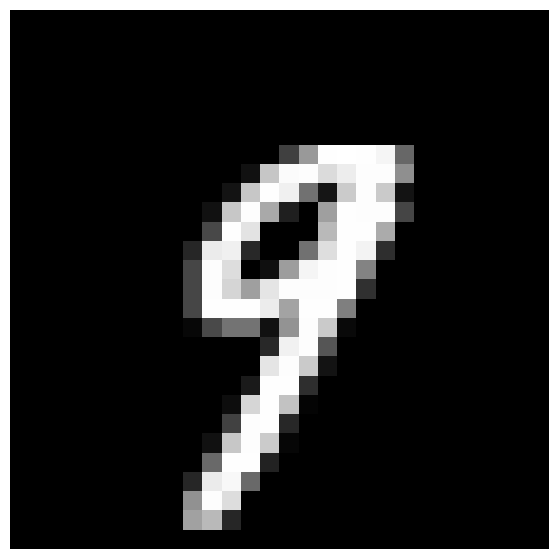

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))  # 전체 figure 크기

plt.imshow(images[0,0].squeeze().numpy(), cmap='gray')
plt.axis('off')

In [3]:
## run this on pnyq..
## NOTE:: This is a very unoptimized version 
## only use this as a template
import numpy as np
import time
from scipy.signal import convolve2d
from tqdm import trange
import torch

device = torch.device("cuda")

mnist = np.load("mnist-original.npy", allow_pickle= True)

X = mnist.item().get("data").T / 255
y = mnist.item().get("label")[0]

In [83]:
from tqdm import tqdm

weights = np.load('qat_bnn_model.npy',allow_pickle=True)

conv1w = weights.item().get('conv1w')
conv2w = weights.item().get('conv2w')
conv3w = weights.item().get('conv3w')
fc3w = weights.item().get('fc1w')
fc3b = weights.item().get('fc1b')

batch_size = 100


def avg_pool2d(x, kernel_size=2, stride=2):
    batch_size, channels, height, width = x.shape

    out_height = height // kernel_size
    out_width = width // kernel_size
    
    x_summed = np.add.reduceat(np.add.reduceat(x, np.arange(0, height, stride), axis=2), 
                               np.arange(0, width, stride), axis=3)
    
    x_pooled = x_summed / (kernel_size * kernel_size)
    
    return x_pooled

def feed_foward(X0):
    ## unfortunately, I found no efficient implementation of 2D Conv without using pytorch 
    ## this code is VERY SLOW. Just use this to see the correctness of the results 
    X0 = X0.reshape(-1, 1, 28, 28)
    X1 = np.zeros((batch_size, 16, 26, 26))  # Temporary buffer for X1
    X2 = np.zeros((batch_size, 16, 24, 24))  # Temporary buffer for X2
    X3 = np.zeros((batch_size, 32, 22, 22))  # Temporary buffer for X2
    ## conv1 layer
    for b in range(batch_size):
        for co in range(16):
            X1[b,co] = convolve2d(X0[b,0], conv1w[co, 0][::-1, ::-1], mode='valid')

    ## ReLU        
    X1 = np.sign(X1)
    #X1[X1<0] = 0

    ## conv2 layer
    for b in range(batch_size):
        for co in range(16):
            for ci in range(16):
                X2[b,co] += convolve2d(X1[b,ci], conv2w[co, ci][::-1, ::-1], mode='valid')    

    X2 = np.sign(X2)
    #X2[X2<0] = 0

    for b in range(batch_size):
        for co in range(32):
            for ci in range(16):
                X3[b,co] += convolve2d(X2[b,ci], conv3w[co, ci][::-1, ::-1], mode='valid')    

    X3 = np.sign(X3)
    #X3[X3<0] = 0

    A3 = avg_pool2d(X3)
    A3 = A3.reshape(-1, 3872)
    X3 = np.matmul(A3, fc3w.T) + fc3b

    return X3
            

correct = 0
total = 0

pbar = tqdm(range(len(X) // batch_size), desc="Evaluating", dynamic_ncols=True)
for idx in pbar:
    xs = X[batch_size * idx : batch_size * idx + batch_size]
    ys = y[batch_size * idx : batch_size * idx + batch_size]
    outputs = feed_foward(xs)

    predictions = np.argmax(outputs, axis=1)
    correct += np.sum(predictions == ys)
    total += len(ys)

    acc = (correct / total) * 100
    pbar.set_postfix(accuracy=f"{acc:.2f}%")

print(f"\n✅ Final Accuracy: {acc:.2f}%")

Evaluating: 100%|██████████| 700/700 [16:02<00:00,  1.38s/it, accuracy=86.15%]


✅ Final Accuracy: 86.15%
